# Word Embeddings : le modèle Word2Vec

## Imports

In [1]:
import sys

# library to build bi-grams
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode

## Chargement et traitement des phrases du corpus

### Création d'un objet qui *streame* les lignes d'un fichier pour économiser de la RAM

In [2]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [3]:
infile = f"../data/sents.txt"
sentences = MySentences(infile)

### Détection des bigrams

In [4]:
bigram_phrases = Phrases(sentences)

In [5]:
type(bigram_phrases.vocab)

dict

In [6]:
len(bigram_phrases.vocab.keys())

2643925

Prenons une clé au hasard :

In [9]:
key_ = list(bigram_phrases.vocab.keys())[145]
print(key_)

maladie


In [10]:
bigram_phrases.vocab[key_]

1137

### Conversion des `Phrases` en objet `Phraser`

`Phraser` est un alias pour `gensim.models.phrases.FrozenPhrases`, voir ici https://radimrehurek.com/gensim/models/phrases.html.

Le `Phraser` est une version *light* du `Phrases`, plus optimale pour transformer les phrases en concaténant les bigrams.

In [11]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

Le `Phraser` est un objet qui convertit certains unigrams d'une liste en bigrams lorsqu'ils ont été identifiés comme pertinents.

### Extraction des trigrams

Nous répétons l'opération en envoyant cette fois la liste de bigrams afin d'extraire les trigrams.

In [13]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [14]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

### Création d'un corpus d'unigrams, bigrams, trigrams

In [15]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

In [16]:
print(corpus[:10])

[['v', 'i', 'l', 'l', 'e', 'de', 'bruxelles', 'bulletin', 'ires', '8eanas', 'dl', '!'], ['conseil_communal', 'annee', '1847', '.'], ['au', 'ville', 'de', 'b', 'r', 'u', 'x', 'e', 'l', 'l', 'e', 's', '.'], ['bulletin', 'conseil', 'aes', 'seances', 'communal', '.'], ['annee', '1847', '.'], ['bruxelles', ',', 'imprimerie', 'd', 'e', 'j', '.'], ['h', '.', 'b', 'r', 'i', 'a', 'r', 'd', ',', 'rite', 'n', 'e', 'u', 'v', 'e', ',', '3', '1', ',', 'faubourg', 'de', 'n', 'a', 'm', 'u', 'r', ',', '1', '84', '8', 'de', '!'], ['du', 'consei', 'dibi', 'e', '.', '-', 'communication', 'conclusions', 'de', 'la', 'section', 'des', 'du', 'nouvel_hospice', 'pour', 'les', 'av', 'enraisonde', 'l', "'", 'absence', '&', 'maladie', '.', 'le', 'conseil', 'ajourne', 'leurs', 'de', 'pierre', 'el', 'marchai', 'cles', 'des', 'taxes', 'communale', "'", 'bieniaance', 'eldeseianv', 'il', 'est', 'donne', 'communie', ';', 'mandant', 'le', 'o', 'p', 'fa', 'gnant', 'l', "'", 'envoi', 'de', 'leur', 'bn', 'par', 'l', "'", 'e

## Entrainement d'un modèle Word2Vec sur ce corpus

In [17]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=5, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=5, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

CPU times: user 10min 39s, sys: 17.8 s, total: 10min 57s
Wall time: 6min 12s


#### Remarque

Vous voyez ici que l'entrainement du modèle est parallélisé (sur 4 workers).

Lors qu'on parallélise l'entrainement du modèle, 4 modèles "séparés" sont entrainés sur environ un quart des phrases.

Ensuite, les résultats sont agrégés pour ne plus faire qu'un seul modèle.

On ne peut prédire quel worker aura quelle phrase, car il y a des aléas lors de la parallélisation (p. ex. un worker qui serait plus lent, etc.).

Du coup, les valeurs peuvent varier légèrement d'un entrainement à l'autre.

Mais, globalement, les résultats restent cohérents.

### Sauver le modèle dans un fichier

In [18]:
outfile = f"../data/bulletins.model"
model.save(outfile)

## Explorer le modèle

### Charger le modèle en mémoire

In [19]:
model = Word2Vec.load("../data/bulletins.model")

### Imprimer le vecteur d'un terme

In [20]:
model.wv["bruxelles"]

array([-2.2407947 , -1.9811676 ,  1.326188  ,  1.1673878 ,  0.92578995,
        0.6234922 , -3.5931273 , -3.4063377 , -2.5758986 ,  2.9296966 ,
       -3.7395635 , -0.43881273, -1.8364091 ,  2.7945979 , -2.051373  ,
       -3.6095848 , -0.49859163,  4.316807  ,  1.188188  , -0.28777516,
        2.2515326 , -2.1838012 , -1.6108451 ,  2.44703   , -2.0912445 ,
       -0.5849405 ,  1.493627  ,  1.5401726 , -2.227346  , -3.0829668 ,
       -2.76115   , -1.3288624 ], dtype=float32)

### Calculer la similarité entre deux termes

In [110]:
# Cuanto más alejadas las palabras -1 y cuanto más cercanas 1
# model.wv.similarity("boucher", "boulanger")
# model.wv.similarity("bourgmestre", "ministre")

model.wv.similarity("place", "parc")

0.45054004

In [122]:
model.wv.similarity("route", "rue")

0.63251853

In [121]:
model.wv.similarity("conseil", "college")

0.91702294

### Chercher les mots les plus proches d'un terme donné

In [83]:
model.wv.most_similar("belgique", topn=10)

[('france', 0.9251067638397217),
 ('allemagne', 0.8622754812240601),
 ('angleterre', 0.8233621120452881),
 ('zurich', 0.79856938123703),
 ('italie', 0.7972203493118286),
 ('hollande', 0.7704367637634277),
 ('londres', 0.7692067623138428),
 ('berlin', 0.7640076279640198),
 ('hambourg', 0.7570380568504333),
 ('liege', 0.7551849484443665)]

In [123]:
model.wv.most_similar("quartier", topn=10)

[('quartier_leopold', 0.8431769609451294),
 ('bassin', 0.8284267783164978),
 ('voisinage', 0.8264437317848206),
 ('parc', 0.8148473501205444),
 ('perimetre', 0.8107870221138),
 ('centre', 0.8016929030418396),
 ('coin', 0.7972183227539062),
 ('boulevard', 0.795576810836792),
 ('comblement', 0.7934969663619995),
 ('redressement', 0.7915669083595276)]

In [124]:
model.wv.most_similar("devis", topn=10)

[('plan', 0.821343719959259),
 ('projet', 0.7189451456069946),
 ('projet_primitif', 0.7131989002227783),
 ('plan_primitif', 0.7058727145195007),
 ('plan_definitif', 0.7058706283569336),
 ('plan_general', 0.7031134963035583),
 ('nouveau_reglement', 0.6996601819992065),
 ('contrat', 0.6994868516921997),
 ('resultat', 0.6984244585037231),
 ('complement', 0.6977359652519226)]

## Graphique des mots les plus proches d'un terme donné

### Imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

In [102]:
# Here it is interesting to change the word, and the topn to see a differents results in chart
#word_list = dict(model.wv.most_similar("belgique", topn=20)).keys()
word_list = dict(model.wv.most_similar("belgique", topn=10)).keys()

# Loop to save each most_similar topn10 vector 
word_vectors = {}
for word in word_list:
    vectors = model.wv[word]
    word_vectors[word] = vectors

### Réduire les vecteurs à 2 dimensions

Documentation de la fonction https://towardsdatascience.com/how-to-draw-a-map-using-python-and-word2vec-e9627b4eae34

In [106]:

def plot_2d_representation_of_words(
    word_list, 
    word_vectors, 
    flip_x_axis = False,
    flip_y_axis = False,
    label_x_axis = "x",
    label_y_axis = "y", 
    label_label = "X"):
    
    pca = PCA(n_components = 2)
    
    word_plus_coordinates=[]
    
    for word in word_list: 
        current_row = []
        current_row.append(word)
        current_row.extend(word_vectors[word])
        word_plus_coordinates.append(current_row)

    word_plus_coordinates = pd.DataFrame(word_plus_coordinates)
    loc = word_plus_coordinates.iloc[:,1:32]

    coordinates_2d = pca.fit_transform(
        loc)
    coordinates_2d = pd.DataFrame(
        coordinates_2d, columns=[label_x_axis, label_y_axis])
    coordinates_2d[label_label] = word_plus_coordinates.iloc[:,0]
    
    if flip_x_axis:
        coordinates_2d[label_x_axis] = \
        coordinates_2d[label_x_axis] * (-1)
    if flip_y_axis:
        coordinates_2d[label_y_axis] = \
        coordinates_2d[label_y_axis] * (-1)
            
    plt.figure(figsize = (15,10))
    p1=sns.scatterplot(
        data=coordinates_2d, x=label_x_axis, y=label_y_axis)
    
    x = coordinates_2d[label_x_axis]
    y = coordinates_2d[label_y_axis]
    label = coordinates_2d[label_label]
    
    texts = [plt.text(x[i], y[i], label[i]) for i in range(len(x))]

### Générer le plot

#### Plot avec un topn=10

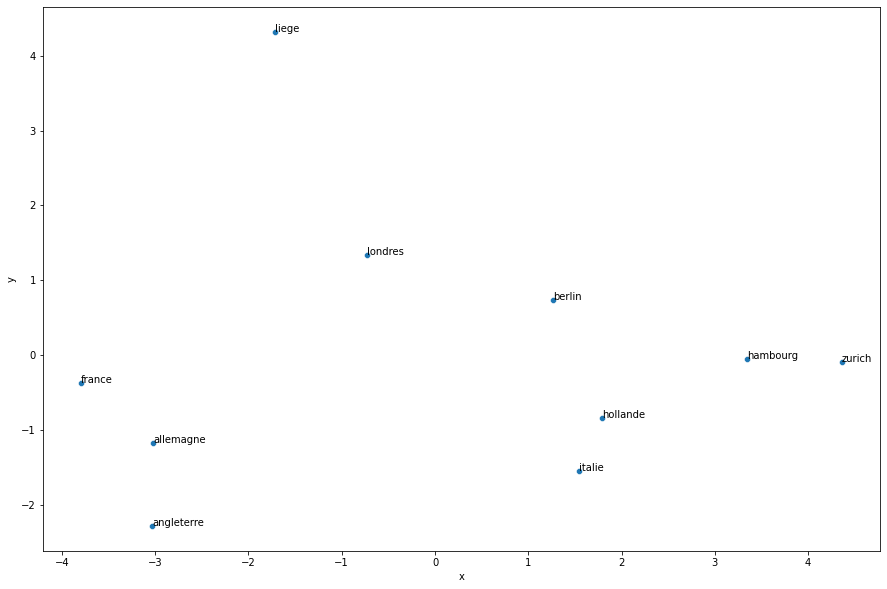

In [104]:
plot_2d_representation_of_words(
    word_list = word_list, 
    word_vectors = word_vectors, 
    flip_y_axis = False)

#### Plot avec un topn=20

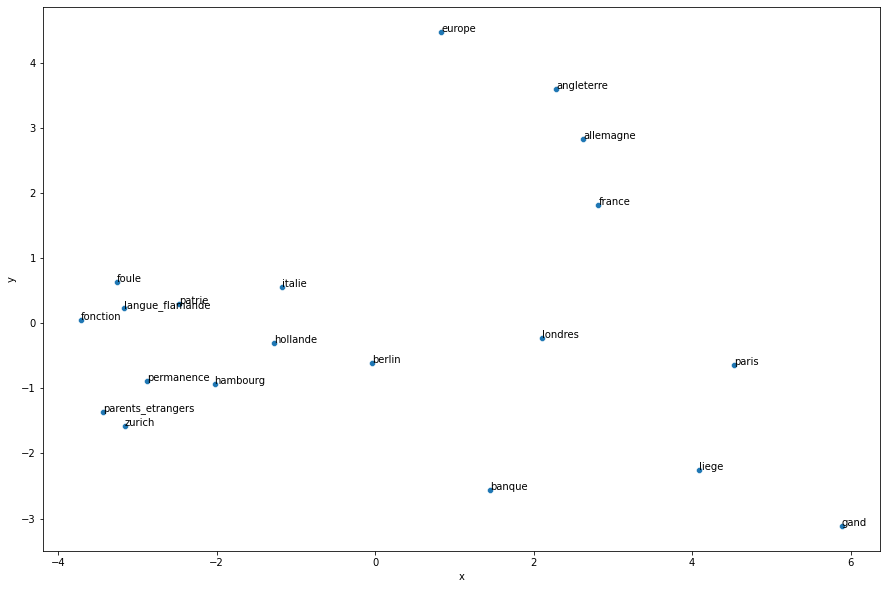

In [107]:
plot_2d_representation_of_words(
    word_list = word_list, 
    word_vectors = word_vectors, 
    flip_y_axis = False)